## Import modules

In [1]:
import model_openface as mo ## custom helper module
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
original_path = os.getcwd()

Using TensorFlow backend.


## Construct a predefined model/weights for face recognition ([OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace))

In [2]:
model = mo.model_openface()
mo.load_weight_openface(model)

## parameters

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img_row = 96
img_col = 96
box_size_factor = 7.5 # bigger value allows smaller bounding box
face_recog_thresh = 0.6

db_img_sean = cv2.imread('image_database/sean.jpg')
db_img_jason = cv2.imread('image_database/jason.jpg')

test_img_sean = cv2.imread('test/sean.jpg')
test_img_jason = cv2.imread('test/jason.jpg')
test_img_multi = cv2.imread('test/multi.jpg')
test_img_gia_sean = cv2.imread('test/gia_sean.jpg')
test_img_james_yena = cv2.imread('test/james_yena.png')

## `detect_face` to detect frontal faces in *gray* and crop in *RGB*
## `plot_detect_face` to plot the results


In [4]:
def detect_face(img,fc=face_cascade,flag='db'):
    '''
    default: flag = 'db' --> assume only one face is present in the image and return only 1 face
    flag = 'new' --> if to embed new images (possibly multiple faces)
    '''
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height,width = img_grey.shape
    faces_raw = fc.detectMultiScale(img_grey) # higher accuracy for faces with black glasses
    faces = []
    for face in faces_raw:
        if face[2] > (min(height,width)/box_size_factor):
            faces.append(face)
    if flag == 'db':
        face_box = [0,0,0,0]
        for (x, y, w, h) in faces:
            if w > face_box[2]:
                face_box = [x,y,w,h] # IGNOTE ALL OTHER FALSY FACE BOXES
        x,y,w,h = face_box
        cropped_list = img_color[y:y+h,x:x+w].copy() # crop without a bounding box 
        cropped_list = [cropped_list]
        img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)
    if flag == 'new':
        cropped_list = []
        for (x, y, w, h) in faces: # crop without a bounding box
            cropped = img_color[y:y+h,x:x+w].copy()
            cropped_list.append(cropped)
        for (x, y, w, h) in faces:
            img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)
    return img_color,cropped_list,faces

In [5]:
def plot_detect_face(img,flag='db'):
    '''
    plot the full image with a bouding box around the face
    plot the cropped faces
    default: flag = 'db' --> assume only one face is present in the image and return only 1 face
    flag = 'new' --> detect multiple faces with lower accuracy
    '''
    num_col = 5
    result_img,cropped_list,_ = detect_face(img,flag=flag)
    plt.axis('off')
    plt.title('full image',fontdict={'fontsize':15,'fontweight':'bold'})
    plt.imshow(result_img)
    if len(cropped_list)==1: 
        fig,ax=plt.subplots(1,1,figsize=(3,3))
        ax.imshow(cropped_list[0])
        ax.axis('off')
        fig.suptitle('Cropped face image to be embedded',fontsize=15,fontweight='bold')
    elif len(cropped_list)<=num_col: 
        fig,axes=plt.subplots(1,len(cropped_list),figsize=(3*len(cropped_list),3))
        for ax,cropped in zip(axes.flatten(),cropped_list):
            ax.imshow(cropped)
            ax.axis('off')
        fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')
    else:
        fig, axes = plt.subplots(int(np.ceil(len(cropped_list)/num_col)),num_col,figsize=(15,3*int(np.ceil(len(cropped_list)/num_col))))
        for ax,cropped in zip(axes.flatten(),cropped_list):
            ax.imshow(cropped)
            ax.axis('off')
        fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')
        if not len(cropped_list)==len(axes.flatten()):
            for i in axes.flatten()[len(cropped_list)-len(axes.flatten()):]:
                i.set_visible(False)

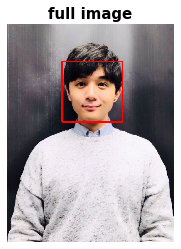

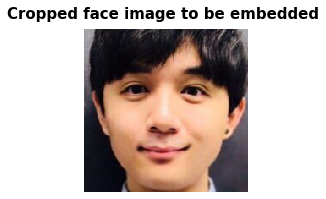

In [6]:
plot_detect_face(db_img_sean)

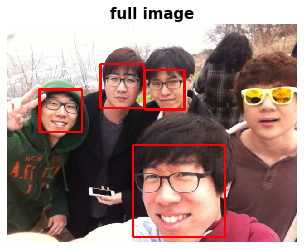

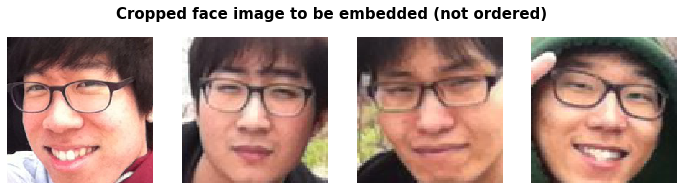

In [7]:
plot_detect_face(test_img_multi,flag='new')

In this case, my face was not detected possibly due to the sunglasses! 

## `embed_image` to embed images

In [8]:
def embed_image(face_img,model):
    '''
    embed the cropped face (input) into 128d vector
    use with `detect_face()`
    '''
    img = cv2.resize(face_img, (img_row,img_col)).astype('float32')
    img /= 255.0
    img = np.expand_dims(img,axis=0)
    embedding = model.predict_on_batch(img)
    return embedding

## `database_face_embedding` to process and embed images in the database

In [9]:
def database_face_embedding():
    '''
    embed the images in the database
    output = {'name':embedding,...}
    '''
    database_embeddings = {}
    os.chdir(os.path.join(os.getcwd(),'image_database'))
    for img_file in os.listdir():
        name = img_file.split('.')[0]
        image_file = cv2.imread(img_file)
        _,face_img,_ = detect_face(image_file,fc=face_cascade,flag='db')
          
        database_embeddings[name] = embed_image(face_img[0], model)
    os.chdir(original_path)
    return database_embeddings

In [10]:
database_embeddings = database_face_embedding()
registered_name = list(database_embeddings.keys())
print('Current database contains {} images: \n{}'.format(len(database_embeddings),[key.upper() for key in registered_name]))

Current database contains 7 images: 
['GIA', 'JAMES', 'JASON', 'LUCY', 'SEAN', 'TONY', 'YOUNG']


## `face_recog` to recognize multiple registered faces from an image!

In [11]:
def face_recog(new_image,database_embeddings,model,size): # now embed_image generate only one set of embed
    '''
    size --> generate sizeXsize dimension output image
    '''    
    img_color,faces,faces_coords = detect_face(new_image,flag='new')
    new_embeddings = []
    for face in faces:
        new_embedding = embed_image(face,model)
        new_embeddings.append(new_embedding)
    name_label = ''
    for face_num,(new_embedding,face_coord) in enumerate(zip(new_embeddings,faces_coords)):
        min_dist = 100
        print('face #{}'.format(face_num+1))
        for (registered_name,registered_embedding) in database_embeddings.items():
            euc_dist = np.linalg.norm(new_embedding-registered_embedding)
            print('Distance from {}: {:.3f}'.format(registered_name,euc_dist))
            if euc_dist < min_dist:
                min_dist = euc_dist
                name = registered_name
        if min_dist < face_recog_thresh:
            print('***this is {}!***\n'.format(name.upper()))
            name_label = name
        else:
            print('***not registered!***\n')
            name_label='n/a'
        (x, y, w, h) = face_coord
        text = '{}.{}'.format(face_num+1,name_label)
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,2,5)[0]
        text_offset_x = x-3
        text_offset_y = y
        box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
        if name_label == 'n/a':
            img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (0,0,255), 4)
            img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (0,0,255), cv2.FILLED)    
        else:
            img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 4)
            img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (255,0,0), cv2.FILLED)
        img_color = cv2.putText(img_color,text,(x,y),cv2.FONT_HERSHEY_PLAIN,2,(255,255,255),3)
    plt.figure(figsize=(size,size))
    plt.imshow(img_color)
    plt.axis('off')

## Test on new images!

face #1
Distance from gia: 1.036
Distance from james: 0.815
Distance from jason: 0.000
Distance from lucy: 0.626
Distance from sean: 0.677
Distance from tony: 0.785
Distance from young: 0.775
***this is JASON!***

face #2
Distance from gia: 1.515
Distance from james: 1.404
Distance from jason: 1.100
Distance from lucy: 1.018
Distance from sean: 1.304
Distance from tony: 1.288
Distance from young: 1.152
***not registered!***



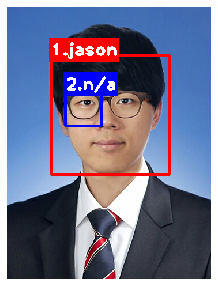

In [12]:
face_recog(db_img_jason,database_embeddings,model,5)

For validation, used the identical picture stored in the database --> 0 distance from *jason* **(model confirmed!)**

face #1
Distance from gia: 0.415
Distance from james: 0.823
Distance from jason: 1.003
Distance from lucy: 0.914
Distance from sean: 0.553
Distance from tony: 1.071
Distance from young: 0.899
***this is GIA!***

face #2
Distance from gia: 0.712
Distance from james: 0.770
Distance from jason: 0.615
Distance from lucy: 0.683
Distance from sean: 0.376
Distance from tony: 0.847
Distance from young: 0.671
***this is SEAN!***



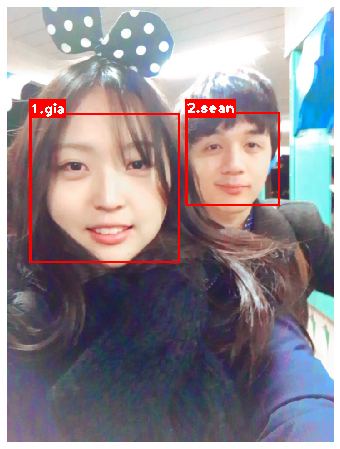

In [13]:
face_recog(test_img_gia_sean,database_embeddings,model,8)

face #1
Distance from gia: 0.804
Distance from james: 0.738
Distance from jason: 0.738
Distance from lucy: 0.729
Distance from sean: 0.564
Distance from tony: 0.791
Distance from young: 0.725
***this is SEAN!***

face #2
Distance from gia: 0.894
Distance from james: 0.962
Distance from jason: 0.837
Distance from lucy: 0.648
Distance from sean: 0.775
Distance from tony: 0.909
Distance from young: 0.835
***not registered!***

face #3
Distance from gia: 1.110
Distance from james: 0.863
Distance from jason: 0.722
Distance from lucy: 0.820
Distance from sean: 0.808
Distance from tony: 0.929
Distance from young: 0.831
***not registered!***

face #4
Distance from gia: 1.229
Distance from james: 0.912
Distance from jason: 0.912
Distance from lucy: 0.988
Distance from sean: 0.924
Distance from tony: 0.949
Distance from young: 0.979
***not registered!***



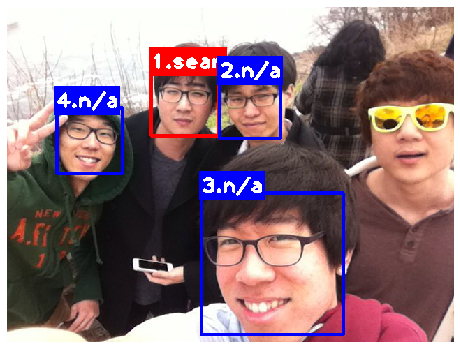

In [14]:
face_recog(test_img_multi,database_embeddings,model,8)